# Detectando Niveles Jugables en Zelda

## Resumen
En este archivo se estará realizando un algoritmo de ML con redes neuronales que tomará imagenes del dataset guardado en el folder `dataset`  con diferentes niveles del videojuego Zelda. La máquina deberá aprender a reconocer si el nivel de la imagen es jugable o no jugable. La manera de reconocer si un nivel es jugable es porque se debe cumplir que:

1. El personaje de Link se encuentre en el nivel
2. Haya al menos una puerta a la que Link pueda avanzar
3. Haya al menos una llave para que Link pueda acceder a la puerta

## Estado de arte

Tras una investigación sobre el estado de arte hubo varias investigaciones que llamaron mi atención para implementar mi modelo. Pero la que mayormente destacó fue una que habla sobre el aprendizaje profundo por refuerzo sensible a objetos [1]. El O-DRL mejora el aprendizaje produnfo por refuerzo al incorporar información sobre objetos en el proceso de aprendizaje. Esto se logra al agregar más canales a la representación del estado del agente que codifican la presencia y ubicación de los objetos detectados en la imagen. Así el agente puede diferenciar entre objetos importantes y evitar objetos dañinos. 

Debido a que en mi dataset y proyecto, las cosas a identificar esenciales son los objetos en los niveles, como lo serían las llaves, puertas y el personaje de Link. Este paper va muy bien para aplicarlo a mi modelo y que sea más fácil en identificar los objetos. Ya que esta técnica ayuda mucha en computer vision para la detección de objetos. En mi caso creo que puedo aplicar la arquitectura que se plantea en el que puedo aplicar hacer el gradiente en mi número de capas. Ir disminuyendo el tamaño de la capa conforme va avanzando. Asimismo, creo que sería buena práctica realizar el mapa de saliencia tal y como lo mencionan en el artículo. Creo que esta implementación puede ayudar a entender cómo está realizando y analizando las imágenes en mi algoritmo. 


### Fuentes
[1] Li, Y., Sycara, K., & Iyer, R. (2018). Object-sensitive deep reinforcement learning. arXiv preprint arXiv:1809.06064.
[2] B. van Oostendorp, “Object Detection for Reinforcement Learning Agents”, Syst. Theor. Control Comput. J., vol. 3, no. 2, pp. 9–14, Dec. 2023, doi: 10.52846/stccj.2023.3.2.51.
[3] Jung M, Yang H, Min K. "Improving Deep Object Detection Algorithms for Game Scenes". Electronics. 2021; 10(20):2527. https://doi.org/10.3390/electronics10202527

In [226]:
#### PACKAGE IMPORTS ####

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os

import cv2
import numpy as np

def hex_to_bgr(hex_color):
    hex_color = hex_color.lstrip('#')
    return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))[::-1]

def remove_color(image_path, color_to_remove):
    # Convert hexadecimal color to BGR color
    color_to_remove = hex_to_bgr(color_to_remove)

    # Load the image
    image = cv2.imread(image_path)

    # Create a mask where color matches the color to remove
    mask = np.all(image == color_to_remove, axis=-1)

    # Change all pixels where the mask is true to white
    image[mask] = [255, 255, 255]

    # Revert mask to return the rest of the image
    mask = np.all(image != [255, 255, 255], axis=-1)

    return image


### Cargar el dataset y procesar los datos

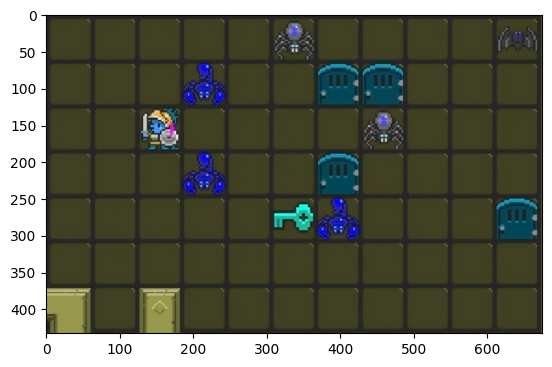

Found 1434 images belonging to 2 classes.
Found 408 images belonging to 2 classes.
Found 206 images belonging to 2 classes.


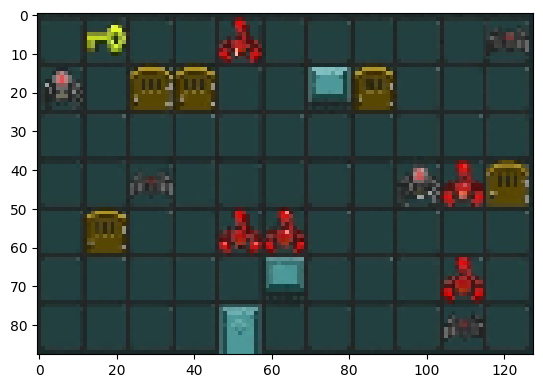

In [232]:
# Rutas a los directorios de entrenamiento y prueba
train_dir = 'dataset/train'
test_dir = 'dataset/test'
val_dir = 'dataset/val'

# Crear generadores de imágenes para entrenamiento y validación
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

image_path = os.path.join(train_dir, 'playable/l85.jpg')
image = cv2.imread(image_path)
plt.imshow(image)
plt.show()

# image_bg_removed = remove_color(image_path, '#224040')
# plt.imshow(image_bg_removed)
# plt.show()
# cv2.imshow('Imagen sin color', image_bg_removed)
# print('image_bg_removed')

BATCH_SIZE = 32
TARGET_SIZE = (88, 128)
EPOCHS = 30

# Cargar las imágenes de entrenamiento y prueba
train_generator = train_datagen.flow_from_directory(
  directory=train_dir,
  target_size=TARGET_SIZE,
  batch_size=BATCH_SIZE,
  class_mode='binary'
)

plt.imshow(train_generator[0][0][0])


test_generator = test_datagen.flow_from_directory(
  directory=test_dir,
  target_size=TARGET_SIZE,
  batch_size=BATCH_SIZE,
  class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
  directory=val_dir,
  target_size=TARGET_SIZE,
  batch_size=BATCH_SIZE,
  class_mode='binary'
)

S

In [150]:
# Definir la arquitectura del modelo CNN
model = Sequential([
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.summary()

# Compilar el modelo
model.compile(optimizer= 'adam',loss= 'binary_crossentropy', metrics = ['accuracy'] )

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_51 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_51 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_52 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_53 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_20 (Flatten)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 13s 259ms/step - accuracy: 0.5094 - loss: 0.6968 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 253ms/step - accuracy: 0.5250 - loss: 0.6932 - val_accuracy: 0.6117 - val_loss: 0.6927
Epoch 3/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 13s 278ms/step - accuracy: 0.5592 - loss: 0.6927 - val_accuracy: 0.5000 - val_loss: 0.6951
Epoch 4/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 14s 293ms/step - accuracy: 0.5128 - loss: 0.6926 - val_accuracy: 0.6311 - val_loss: 0.6904
Epoch 5/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 18s 397ms/step - accuracy: 0.5555 - loss: 0.6884 - val_accuracy: 0.6019 - val_loss: 0.6713
Epoch 6/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 19s 404ms/step - accuracy: 0.6324 - loss: 0.6703 - val_accuracy: 0.7621 - val_loss: 0.5975
Epoch 7/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 19s 421ms/step - accuracy: 0.7332 - loss: 0.5809 - val_accuracy: 0.7670 - val_loss: 0.5230
Epoch 8/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 19s 425ms/step - accuracy: 0.7839 - loss: 0.4746 - val_accu

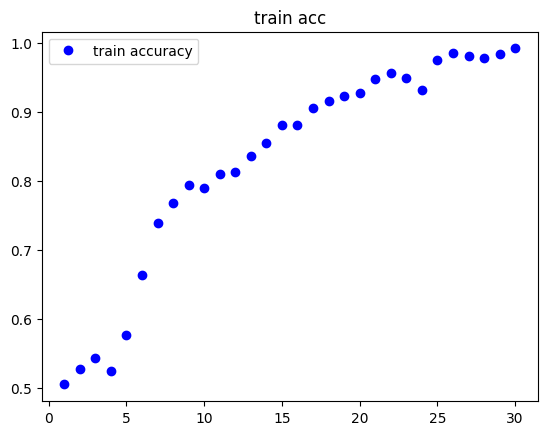

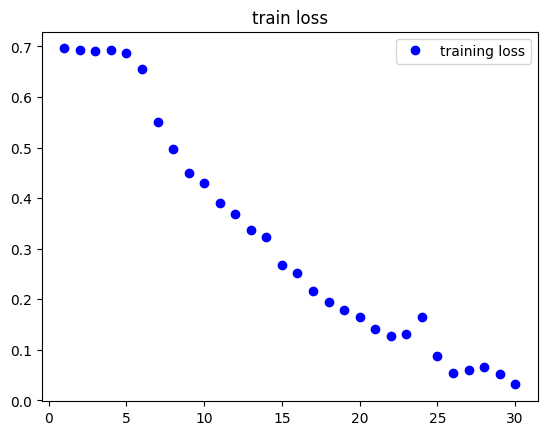

In [151]:
# Entrenar el modelo
history = model.fit(
    train_generator,
    # steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
    validation_data=val_generator,
    # validation_steps=len(val_generator)
)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(test_generator)
print('Precisión en el conjunto de prueba:', test_acc)


acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs,acc,'bo',label='train accuracy')
plt.title('train acc')
plt.legend()

plt.figure()

plt.plot(epochs,loss, 'bo', label ='training loss')
plt.title('train loss')
plt.legend()

plt.show()

model.save("pau.keras")


## Evaluación del modelo
Aquí se realizan los cálculos para realizar la matriz de confusión. 

In [216]:
def check_manually(directory):
  file_predictions = []

  for filename in os.listdir(directory):
    if filename.endswith(".jpg"):
      img_path = os.path.join(directory, filename)
      img = tf.keras.preprocessing.image.load_img(img_path, target_size=TARGET_SIZE)
      img_tensor = tf.keras.preprocessing.image.img_to_array(img)
      img_tensor = np.expand_dims(img_tensor, axis = 0)
      img_tensor /= 255.
      confidence = model.predict(img_tensor,  verbose = 0)
      file_predictions.append((confidence > 0.5).astype("int32"))

  return file_predictions

# Get the predictions for the test set
playable_predictions = check_manually(test_dir + '/playable')
unplayable_predictions = check_manually(test_dir + '/unplayable')

total_playable = len(playable_predictions)
playable = np.array(playable_predictions)
positive_playable = np.sum(playable_predictions)
negative_playable = total_playable - positive_playable

total_unplayable = len(unplayable_predictions)
positive_unplayable = np.sum(np.array(unplayable_predictions))
negative_unplayable = total_unplayable - positive_unplayable

# Cálculo de métricas adicionales
TP = positive_playable
FP = negative_playable
TN = positive_unplayable
FN = negative_unplayable

true_positive_rate = TP / (TP + FN)
false_positive_rate = FP / (FP + TN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * ((precision * recall) / (precision + recall))

print('True positive rate:', true_positive_rate)
print('False positive rate:', false_positive_rate)
print('Precisión:', precision)
print('Sensibilidad (Recall):', recall)
print('Puntuación F1:', f1_score)

# Plot confusion matrix
conf_matrix = [[TP, FP], [FN, TN]]
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


ValueError: Unrecognized data type: x=<keras.src.legacy.preprocessing.image.ImageDataGenerator object at 0x2d300e7c0> (of type <class 'keras.src.legacy.preprocessing.image.ImageDataGenerator'>)